# Offline Phase: generation of the POD modes
This notebook implements the offline phase of the following algorithms:

- Proper Orthogonal Decomposition (POD)

In particular, the basis functions (named *modes*) are generated through the POD procedure.

In [1]:
import numpy as np
import os
from IPython.display import clear_output
import pickle

import gmsh
from mpi4py import MPI
from dolfinx.io.gmshio import model_to_mesh,read_from_msh
from dolfinx.fem import FunctionSpace

from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store
from pyforce.tools.functions_list import FunctionsList
from pyforce.offline.pod import POD

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

path='./Offline_results'
if not os.path.exists(path):
    os.makedirs(path)

The geometry is imported from "ANL11A2_octave.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
gdim = 2

model_rank = 0
mesh_comm = MPI.COMM_WORLD

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('ANL11A2_octave.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Domain
domain, ct, ft = model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

clear_output()

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures.

In [3]:
# Defining the functional space
V = FunctionSpace(domain, ("Lagrange", 1))

# Define the variables to load
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]

# Snapshot path
path_FOM = './Snapshots/'

################ Importing Snapshots ########################
train_snaps = list()

for field_i in range(len(var_names)):
    train_snaps.append(FunctionsList(V))

    tmp_FOM_list, _ = ImportH5(V, path_FOM+'train_snap_'+var_names[field_i], var_names[field_i])
    
    for mu in range(len(tmp_FOM_list)):
        train_snaps[field_i].append(tmp_FOM_list(mu))
    
    del tmp_FOM_list      
            
train_params = list()
for field_i in range(len(var_names)):
    with open(path_FOM+'./train.param', 'rb') as f:
        train_params.append(pickle.load(f))

## POD algorithm

A list will be created for each POD: $0 = \phi_1,\; 1 = \phi_2$.

**How does the POD work?**

Let $u(\mathbf{x};\boldsymbol{\mu})$ be a generic field dependent on space $\mathbf{x}\in\Omega\subset\mathbb{R}^d$ ($d=\{2,3\}$) and parameters $\boldsymbol{\mu}\in\mathcal{D}\subset\mathbb{R}^p$ ($p\geq 1$), let $u_n$ be snapshot for $\boldsymbol{\mu}_n$, i.e. $u_n=u(\mathbf{x}; \boldsymbol{\mu}_n)$.

1. At first, the correlation matrix $\mathbb{C}\in\mathbb{R}^{N_s\times N_s}$ is computed through
\begin{equation*}
\mathbb{C}_{nm} = (u_n, u_m)_{L^2(\Omega)} = \int_{\Omega} u_n\cdot u_m\,d\Omega
\end{equation*}

2. The eigendecomposition of the correlation matrix $\mathbb{C}$ is performed, given $\boldsymbol{\eta}_m$ be the eigenvector and $\lambda_m$ the associated eigenvalue
\begin{equation*}
\mathbb{C} \boldsymbol{\eta}_m = \lambda_m \boldsymbol{\eta}_m
\end{equation*}

3. The basis functions $\psi_m$ (POD modes) are computed through the following
\begin{equation*}
\psi_m = \frac{1}{\sqrt{\lambda_m}}\sum_{n=1}^{N_s} \eta_{m,n}\cdot u_n
\end{equation*}

### Decay of the POD eigenvalues

At first, the eigenvalues are created.

In [4]:
pod_data = [POD(train_snaps[field_i], var_names[field_i], use_scipy=True, verbose = True) for field_i in range(len(var_names))]

Computing phi_1 correlation matrix: 390.000 / 390.00 - 0.127 s/it
Computing phi_2 correlation matrix: 390.000 / 390.00 - 0.127 s/it


Let us plot the eigenvalues

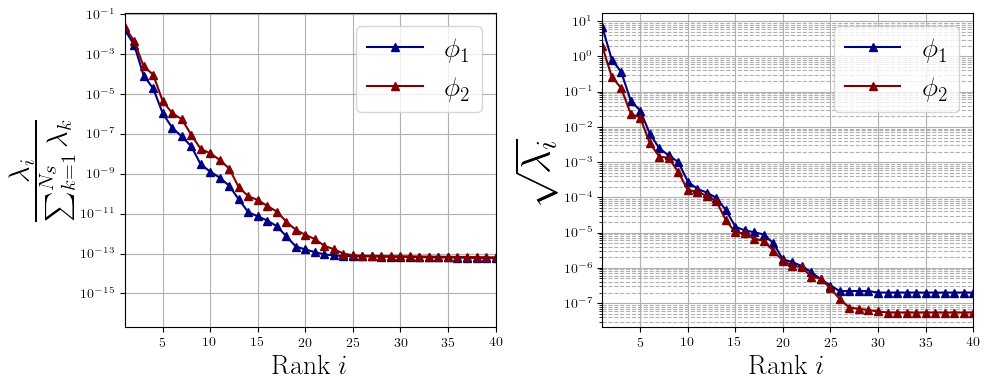

In [5]:
PODeigFig = plt.figure( figsize= (10,4))

plt.subplot(1,2,1)
color = iter(cm.jet(np.linspace(0, 1, len(var_names))))
for field_i in range(len(var_names)):
    c = next(color)
    plt.semilogy(np.arange(1,pod_data[field_i].eigenvalues.size+1,1),
                 1 - np.cumsum(pod_data[field_i].eigenvalues)/sum(pod_data[field_i].eigenvalues), "-^", c=c, label = "$" +tex_var_names[field_i]+"$", linewidth=1.5)   
plt.xlabel(r"Rank $i$",fontsize=20)
plt.xticks(np.arange(0,40+1,5))
plt.xlim(1,40)
# plt.ylim(1e-17, 1.01)
plt.ylabel(r"$\frac{\lambda_i}{\sum_{k=1}^{N_s} \lambda_k}$",fontsize=30)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize=20)

plt.subplot(1,2,2)
color = iter(cm.jet(np.linspace(0, 1, len(var_names))))
for field_i in range(len(var_names)):
    c = next(color)
    plt.semilogy(np.arange(1,pod_data[field_i].eigenvalues[:40].size+1,1),
                 np.sqrt(pod_data[field_i].eigenvalues[:40]), "-^", c=c, label = "$" +tex_var_names[field_i]+"$", linewidth=1.5)   
plt.xlabel(r"Rank $i$",fontsize=20)
plt.xticks(np.arange(0,40+1,5))
plt.xlim(1,40)
plt.ylabel(r"$\sqrt{\lambda_i}$",fontsize=30)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize=20)

plt.tight_layout()

### Definition of the modes
Let us define and save the POD modes.

In [6]:
Nmax = 30

for ii in range(len(var_names)):
    pod_data[ii].compute_basis(train_snaps[ii], Nmax, normalise = True)

if not os.path.exists(path+'/BasisFunctions'):
    os.makedirs(path+'/BasisFunctions')

for ii in range(len(var_names)):
    store(domain, pod_data[ii].PODmodes, 'POD_' +var_names[ii], path+'/BasisFunctions/basisPOD_' + var_names[ii])

### Computing the training error
Then, let us compute the training errors and the POD basis coefficients. 

In [7]:
train_PODcoeff = []

idx_algo = 0
train_abs_err = np.zeros((Nmax, len(var_names)))
train_rel_err = np.zeros((Nmax, len(var_names)))

for ii in range(len(var_names)):
    tmp = pod_data[ii].train_error(train_snaps[ii], Nmax, verbose = True)

    train_abs_err[:, ii] = tmp[0].flatten()
    train_rel_err[:, ii] = tmp[1].flatten()
    
    train_PODcoeff.append(tmp[2])

Computing train error phi_1: 390.000 / 390.00 - 0.072 s/it
Computing train error phi_2: 390.000 / 390.00 - 0.063 s/it


Let us build the store the coefficients of the reduced basis coefficients to be later used.

In [8]:
if not os.path.exists(path+'/coeffs'):
    os.makedirs(path+'/coeffs')

for ii in range(len(var_names)):
    np.savetxt(path+'/coeffs/POD_'+ var_names[ii] + '.txt', train_PODcoeff[ii],  delimiter=',')

The max absolute and relative reconstruction error is compared for the different algorithms, given the following definitions
\begin{equation*}
\begin{split}
E_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\\
\varepsilon_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}
\end{split}
\end{equation*}
given $\mathcal{P}_N[u]$ the reconstruction operator with $N$ basis functions.

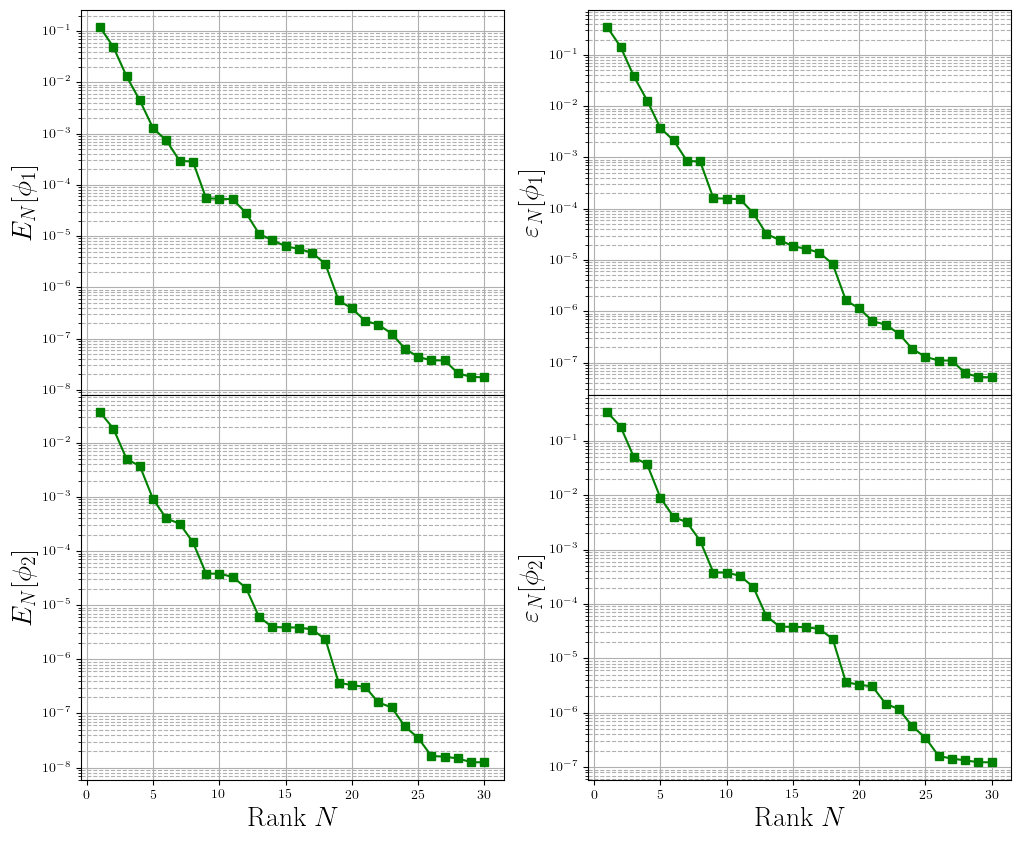

In [9]:
TrainingErrFig, axs = plt.subplots(nrows = len(var_names), ncols = 2, sharex = True, figsize = (12,10) )

Nmax = 30
M = np.arange(1,Nmax+1,1)

for ii in range(len(var_names)):
    
    axs[ii, 0].semilogy(M, train_abs_err[:Nmax, ii], 'g-s',   label = r'POD')
    axs[ii, 1].semilogy(M, train_rel_err[:Nmax, ii], 'g-s',   label = r'POD')

    axs[ii, 0].set_ylabel(r"$E_N["+tex_var_names[ii]+"]$",fontsize=20)
    axs[ii, 1].set_ylabel(r"$\varepsilon_N["+tex_var_names[ii]+"]$",fontsize=20)
    
axs[1, 0].set_xlabel(r"Rank $N$",fontsize=20)
axs[1, 1].set_xlabel(r"Rank $N$",fontsize=20)
    
for ax in axs.flatten():
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')   

TrainingErrFig.subplots_adjust(hspace = 0)